# node2vecで企業ネットワークを埋め込み

In [1]:
import networkx as nx

graphml_file = 'data/kanagawa_yakuin.graphml'

# GraphMLファイルの読み込み
G = nx.read_graphml(graphml_file)

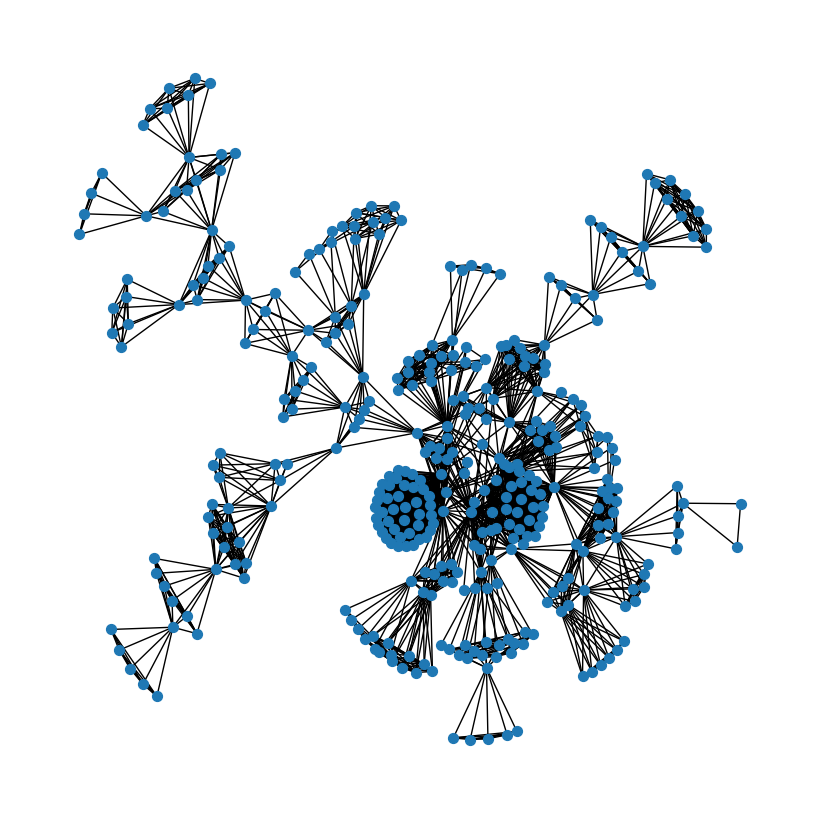

In [2]:
# 可視化
# graphvizバージョン
import matplotlib.pyplot as plt

# 最大連結成分のみ
largest_cc = max(nx.connected_components(G), key=len)
G_draw = G.subgraph(largest_cc)

# グラフ描画
plt.figure(figsize=(8,8)) # 適切なサイズで
nx.draw(G_draw, pos=nx.nx_pydot.graphviz_layout(G_draw), with_labels=False, font_family="MS Gothic", node_size=50, font_size=9)
plt.show()

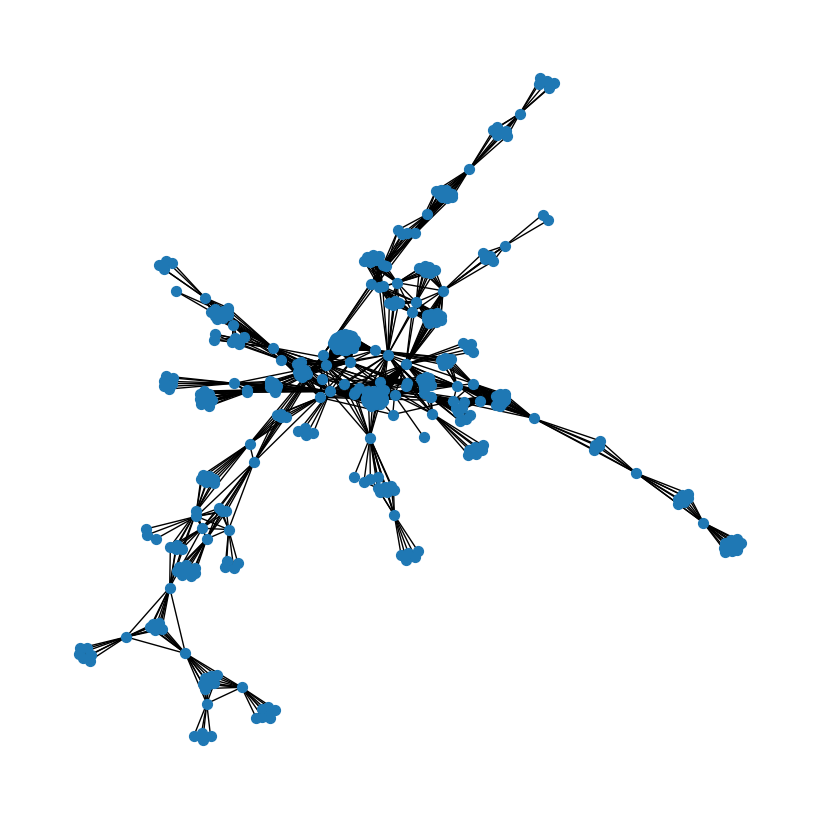

In [4]:
# 可視化
# graphvizを使わないバージョン
import matplotlib.pyplot as plt

# 最大連結成分のみ
largest_cc = max(nx.connected_components(G), key=len)
G_draw = G.subgraph(largest_cc)

# グラフ描画
plt.figure(figsize=(8,8)) # 適切なサイズで
nx.draw(G_draw, with_labels=False, font_family="MS Gothic", node_size=50, font_size=9)
plt.show()

Node2Vec

In [122]:
# 最大連結成分だけ使う
largest_cc = max(nx.connected_components(G), key=len)
G = G.subgraph(largest_cc)

In [123]:
# PyG (PyTorch Geometric)で使える形式に変換
import torch
from torch_geometric.data import Data

# ノードに数値IDを割り当てる（日本語を数値に変換）
mapping = {node: i for i, node in enumerate(G.nodes())}
G_num = nx.relabel_nodes(G, mapping)

# PyGはエッジリストを (2, num_edges) 形式で要求するため、エッジを転置
edge_index = torch.tensor(list(G_num.edges), dtype=torch.long).t().contiguous()

# ノードの特徴量（例として、すべてのノードに特徴量1を設定）
x = torch.ones((G_num.number_of_nodes(), 1))

# PyGのデータ形式に変換
data = Data(x=x, edge_index=edge_index)

print(data)

Data(x=[378, 1], edge_index=[2, 2837])


In [124]:
# モデルの作成
import torch
from torch_geometric.nn import Node2Vec

# GPUが利用可能な場合はGPUを使用し、そうでない場合はCPUを使用
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = Node2Vec(
    data.edge_index,
    embedding_dim=2,
    walk_length=20,
    context_size=10,
    walks_per_node=10,
    num_negative_samples=1,
    p=1.0,
    q=1.0,
    sparse=True,
).to(device)

loader = model.loader(batch_size=128, shuffle=True, num_workers=0)
optimizer = torch.optim.SparseAdam(list(model.parameters()), lr=0.01)

In [16]:
def train():
    model.train()
    total_loss = 0
    for pos_rw, neg_rw in loader:
        optimizer.zero_grad()
        loss = model.loss(pos_rw.to(device), neg_rw.to(device))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

Epoch: 000, Loss: 1.2401
Epoch: 001, Loss: 1.2161
Epoch: 002, Loss: 1.1962
Epoch: 003, Loss: 1.1738
Epoch: 004, Loss: 1.1538
Epoch: 005, Loss: 1.1369
Epoch: 006, Loss: 1.1166
Epoch: 007, Loss: 1.1002
Epoch: 008, Loss: 1.0849
Epoch: 009, Loss: 1.0677
Epoch: 010, Loss: 1.0575
Epoch: 011, Loss: 1.0427
Epoch: 012, Loss: 1.0318
Epoch: 013, Loss: 1.0166
Epoch: 014, Loss: 1.0049
Epoch: 015, Loss: 0.9931
Epoch: 016, Loss: 0.9816
Epoch: 017, Loss: 0.9692
Epoch: 018, Loss: 0.9637
Epoch: 019, Loss: 0.9566
Epoch: 020, Loss: 0.9497
Epoch: 021, Loss: 0.9384
Epoch: 022, Loss: 0.9334
Epoch: 023, Loss: 0.9228
Epoch: 024, Loss: 0.9189
Epoch: 025, Loss: 0.9096
Epoch: 026, Loss: 0.9073
Epoch: 027, Loss: 0.9007
Epoch: 028, Loss: 0.8940
Epoch: 029, Loss: 0.8917
Epoch: 030, Loss: 0.8872
Epoch: 031, Loss: 0.8817
Epoch: 032, Loss: 0.8789
Epoch: 033, Loss: 0.8716
Epoch: 034, Loss: 0.8733
Epoch: 035, Loss: 0.8675
Epoch: 036, Loss: 0.8631
Epoch: 037, Loss: 0.8585
Epoch: 038, Loss: 0.8560
Epoch: 039, Loss: 0.8544


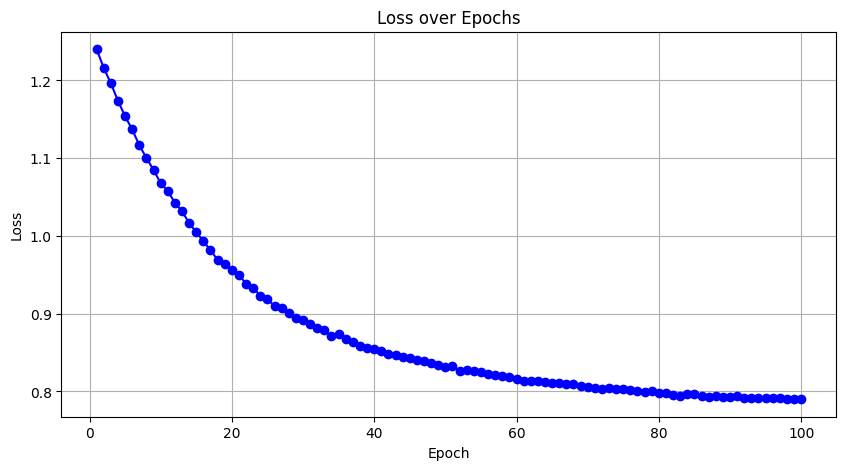

In [125]:
# 学習

# 学習時の損失値を記録するためのリスト
losses = []

num_epochs = 100
for epoch in range(num_epochs):
    loss = train()
    losses.append(loss)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

# 損失値の可視化
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), losses, marker='o', linestyle='-', color='b')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

## 埋め込みの可視化

In [97]:
# 描画する関数
def plot_points(z, node_labels=None):
    """
        z: 埋め込み
        node_labels: G.nodesを指定すればOK 何も指定しなければラベルを表示しない
    """

    plt.figure(figsize=(9, 9))
    plt.scatter(z[:, 0], z[:, 1], s=70, color='b', alpha=0.6)

    # ノードのラベルを表示
    if node_labels:
        for i, label in enumerate(node_labels):
            plt.text(z[i, 0], z[i, 1] + 0.08, label, fontsize=9, ha='center', va='center', fontname="MS Gothic")

    plt.axis('off')
    plt.show()

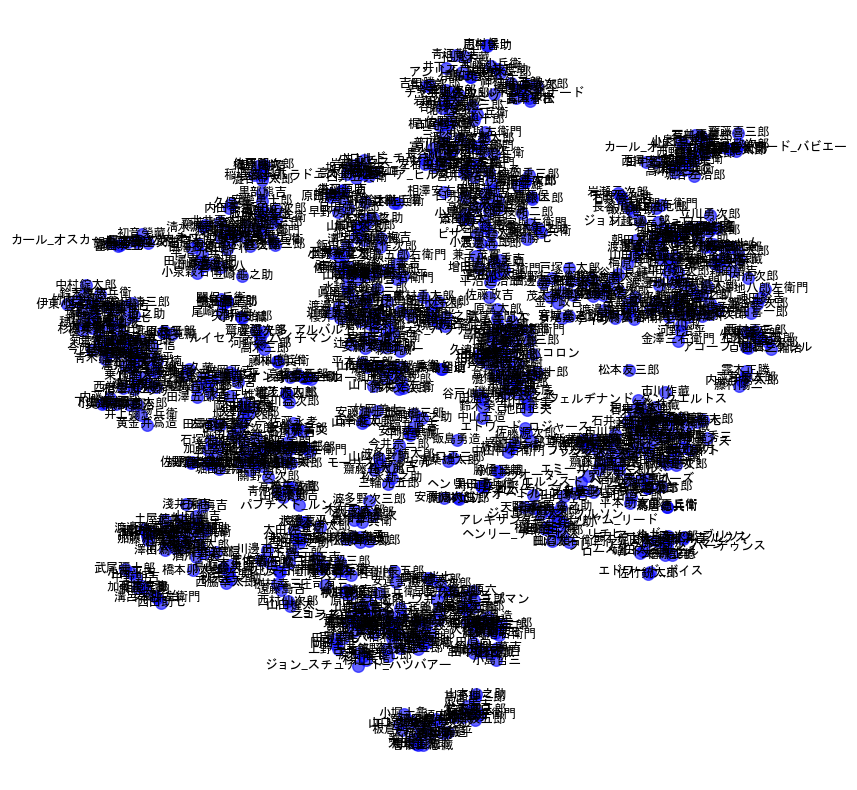

In [99]:
# TSNEを使うパターン
from sklearn.manifold import TSNE

model.eval()
with torch.no_grad():
    z = model().cpu().numpy()
    z = TSNE(n_components=2).fit_transform(z)
    plot_points(z, G.nodes)

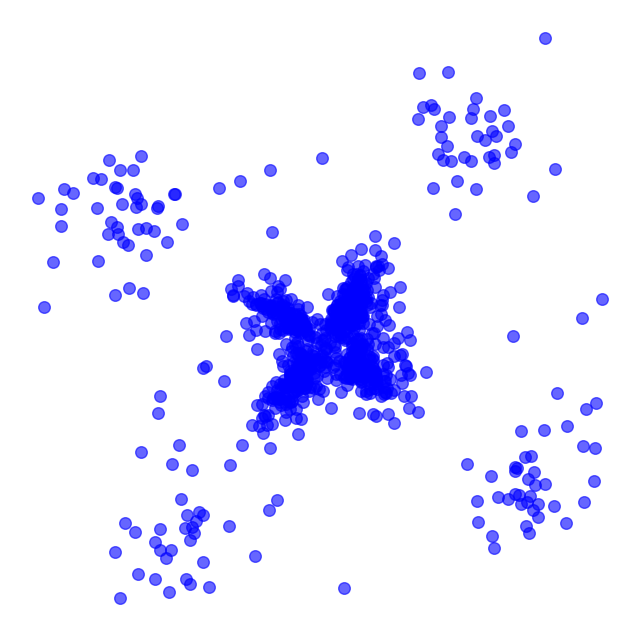

In [84]:
# PCAを使うパターン
from sklearn.decomposition import PCA

model.eval()
with torch.no_grad():
    z = model().cpu().numpy()
    z = PCA(n_components=2).fit_transform(z)
    plot_points(z)

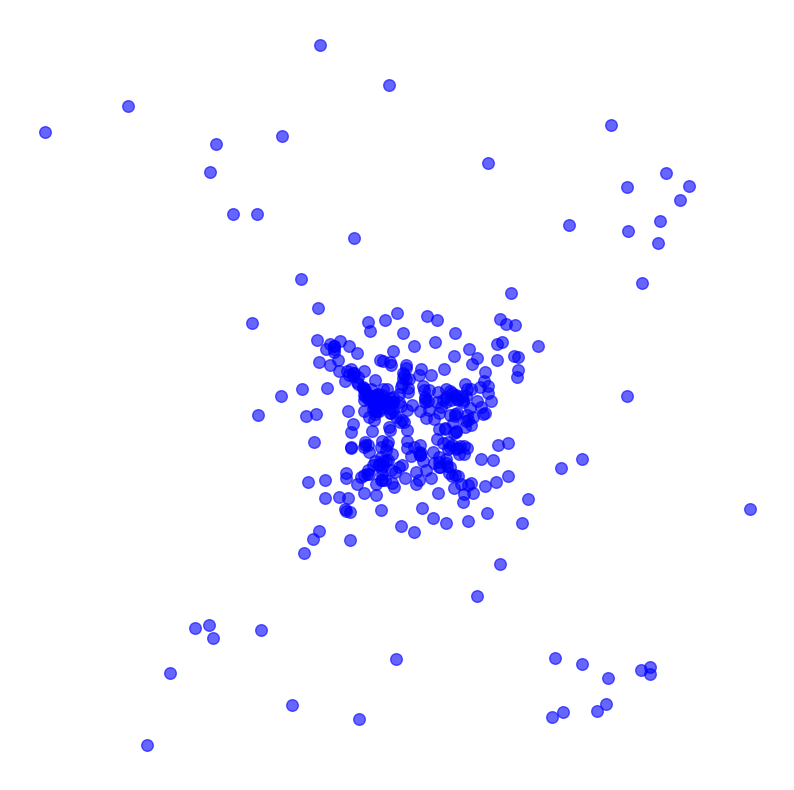

In [127]:
# 2次元の埋め込み
model.eval()
with torch.no_grad():
    z = model().cpu().numpy()
    plot_points(z)

## kmeansでクラスタリング

In [172]:
from sklearn.cluster import KMeans

# 埋め込み表現
model.eval()
with torch.no_grad():
    z = model().cpu().numpy()

n_clusters = 7
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(z)

KMeans(n_clusters=7, random_state=42)

In [161]:
# クラスタリングを可視化
from sklearn.manifold import TSNE
@torch.no_grad()
def plot_clustering(z, colors, n_clusters):
    y = kmeans.labels_

    plt.figure(figsize=(8, 8))
    for i in range(n_clusters):
        plt.scatter(z[y == i, 0], z[y == i, 1], s=20, color=colors[i], label=f'Cluster {i}')
    plt.axis('off')
    plt.legend(title='Clusters')
    plt.show()


colors = [
    '#ffc0cb', '#bada55', '#008080', '#420420', '#7fe5f0', '#ff0000', '#ffd700'
]

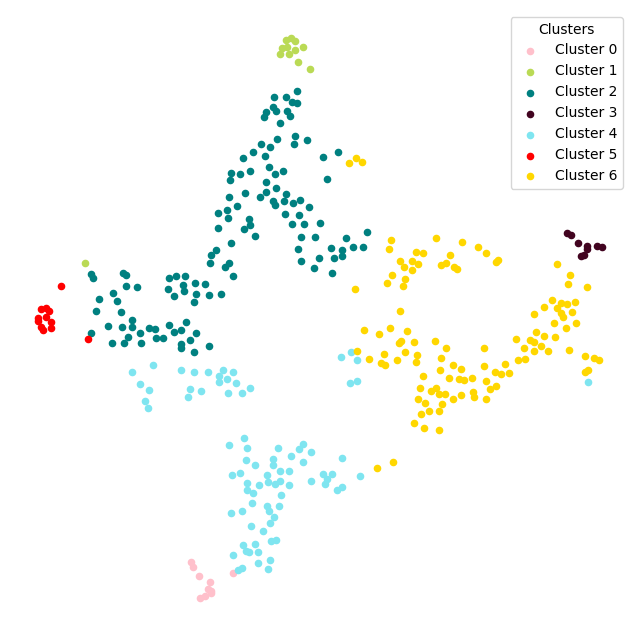

In [174]:
# TSNEを使う場合
model.eval()
with torch.no_grad():
    z = model().cpu().numpy()
    z = TSNE(n_components=2).fit_transform(z)
    plot_clustering(z, colors, n_clusters)

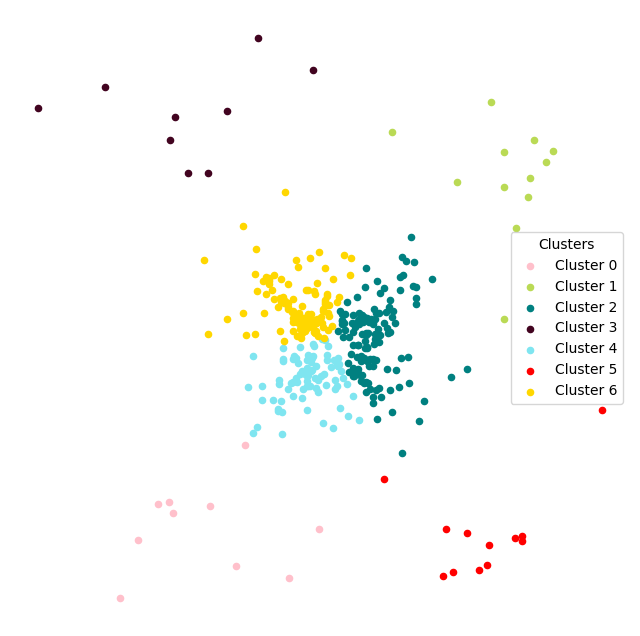

In [173]:
# 2次元の埋め込みの場合
model.eval()
with torch.no_grad():
    z = model().cpu().numpy()
    plot_clustering(z, colors, n_clusters)

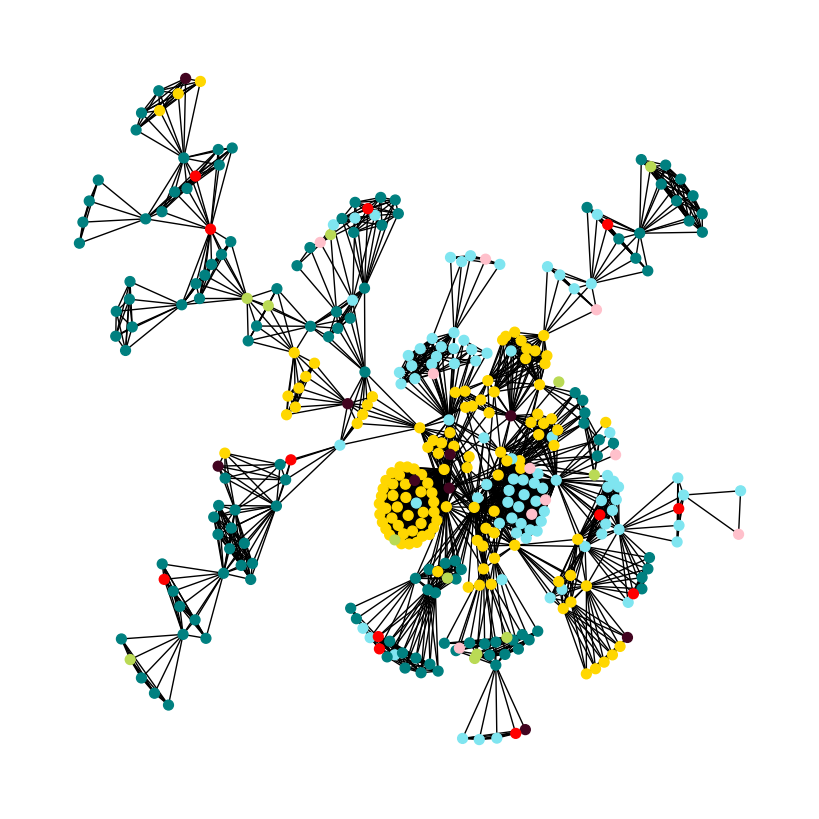

In [175]:
# ネットワークでクラスタリングを可視化
# graphvizバージョン
import matplotlib.pyplot as plt

G_draw = G

# グラフ描画
# 上の埋め込みのクラスタ描画と色を一致させたい
node_colors = [colors[label % len(colors)] for label in kmeans.labels_]

plt.figure(figsize=(8,8)) # 適切なサイズで
nx.draw(G_draw,
        pos=nx.nx_pydot.graphviz_layout(G_draw),
        with_labels=False,
        font_family="MS Gothic",
        node_size=50,
        font_size=9,
		node_color=node_colors
		)
plt.show()


In [179]:
# ノードとクラスタラベルのペアをデータフレームに作成
import pandas as pd

df_clusters = pd.DataFrame({
    'Node': G.nodes,
    'Cluster': kmeans.labels_
})

In [183]:
df_clusters[df_clusters["Cluster"] == 6]

,Node,Cluster
7,田中林藏,6
11,脇庄三郎,6
15,三崎龜之助,6
27,鍋倉直,6
32,樋口源六,6
...,...,...
350,堀谷左治郎,6
351,長鉾郎,6
352,植田鐘三郎,6
360,杉原泰雄,6


In [182]:
df_clusters[df_clusters["Node"] == "若尾幾造"]

,Node,Cluster
246,若尾幾造,6
